In [1]:
# We want to consider the surface wind response to SST structures in different relevant areas of the globe.
# We use L3U  and L4 ESA CCI SST data and L2 12km ASCAT wind data taking data from overlapping swaths. 
# Quality flag check are performed both on SST and wind data.
# This Notebook reads the files that have been computed separately with the multiple_days_stat_L3USST and 
# multiple_days_stat_L4SST.
# A section to compare ERA5 data and L4 data is added.

In [5]:
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import glob
import datetime as dt
import gzip
import cdsapi
import tarfile
import h5netcdf
from numpy import random
from scipy.interpolate import griddata, interp1d
from scipy.ndimage import gaussian_filter
from scipy import stats
from scipy.ndimage import correlate
import geometry as gm # grad_sphere, div_sphere, nan_gaussian_filter, L2wind_2_regular_grid_mask
import distributions as dstr # mixed_distribution, mixed_distribution_with_hist
from matplotlib.offsetbox import AnchoredText

In [6]:
def fixed_bin_distribution_multiple_files(str_a,str_b,max_control,units,nbins,list_str_start,list_str_end,
                                          SSTtype,psi):
    """
    Compute the fixed bin distribution for the variables defined by str_a and str_b, in the area defined by area_str
    reading the files following list_str_start, as a function of the SSTtype and psi.
    """
    distribution_fb = np.zeros(nbins)
    distribution_control_fb = np.zeros(nbins)
    number_of_points_fb = np.zeros(nbins)
    bin_edges_fb = np.linspace(-max_control,max_control,nbins,endpoint=False)

    for tt,str_start in enumerate(list_str_start):
        print(str_start)
        str_end = list_str_end[tt]

        if SSTtype=='L4':
            if psi==0:
                file2read = area_str + '_allvalues_' + str_b + '_vs_' + str_a + '_from_' + str_start + '_to_' + str_end + '_sigma' + str(sigma) + '.txt'
            else:
                file2read = area_str + '_allvalues_' + str_b + '_vs_' + str_a + '_from_' + str_start + '_to_' + str_end + '_sigma' + str(sigma) + '_psi' + str(psi) +'.txt'
        elif SSTtype=='L3U':
            if psi==0:
                file2read = area_str + '_allvalues_' + str_b + '_vs_' + str_a + '_from_' + str_start + '_to_' + str_end + '_sigma' + str(sigma) + '_L3Usst.txt'
            else:
                file2read = area_str + '_allvalues_' + str_b + '_vs_' + str_a + '_from_' + str_start + '_to_' + str_end + '_sigma' + str(sigma) + '_L3Usst_psi' + str(psi) + '.txt'
        elif SSTtype=='ERA5monthly':
            file2read = area_str + '_allvalues_' + str_b + '_vs_' + str_a + '_from_' + str_start[0:7] + '_to_' + str_end[0:7] + '_sigma' + str(sigma) + '_era5monthly.txt'
        elif SSTtype=='ERA5daily':
            file2read = area_str + '_allvalues_' + str_b + '_vs_' + str_a + '_from_' + str_start + '_to_' + str_end + '_sigma' + str(sigma) + '_era5daily.txt'
       
        #df = pd.read_csv('/media/agostino/sailboat/glauco/output_txt/'+file2read)
        df = pd.read_csv('/media/agostino/twiga-polimi-3/glauco/output_txt/'+file2read)

        #aL4.extend(df['control'].values.tolist())
        #bL4.extend(df['response'].values.tolist())
        #UL4.extend(df['background_ws'].values.tolist())

        # Do not extent the lists, otherwise the RAM will be filled.
        control = df['control'].to_numpy()/units; # Forcing field.
        variable = df['response'].to_numpy(); # Atmospheric response field.
        #U = df['background_ws'].to_numpy(); # Background wind speed.

        for qq,lower in enumerate(bin_edges_fb):
            upper = lower + bw

            distribution_fb[qq] += np.nansum(variable[(control>=lower)&(control<upper)])
            distribution_control_fb[qq] += np.nansum(control[(control>=lower)&(control<upper)])
            number_of_points_fb[qq] += np.sum(~np.isnan(variable[(control>=lower)&(control<upper)]))
    
    distribution = distribution_fb/number_of_points_fb
    distribution_control = distribution_control_fb*units/number_of_points_fb
    number_of_points = number_of_points_fb

    return distribution_control,distribution,number_of_points
    

In [7]:
def nonlinear_metrics(x,y,n,threshold):
    """
    Compute the linear regression line for the central 90% of points of the distribution.
    With this, compute the mean signed difference between the y and the linear fit, to measure the nonlinearity.
    x and y are the variables of interest [S.I. units] and n is the number of points for each value of x.
    The ratio of the areas under the linear fit and the experimental points are computed.
    threshold indicates the minimum number of points that a bin has to contain in order to be used for the 
    computation of the area ratios.
    """
    from scipy import stats

    # Define the 5th and 95th percentiles of x, named x5 and x95, expoiting the information in n.
    ntot = np.sum(n)
    cdf = np.cumsum(n)/ntot
    i5 = np.argmin(np.abs(cdf-0.05))
    i95 = np.argmin(np.abs(cdf-0.95))
    x5 = x[i5]
    x95 = x[i95]

    # Perform the linear regression over this subset of points.
    sub_x = x[(x>=x5)&(x<=x95)]
    sub_y = y[(x>=x5)&(x<=x95)]
    sub_lsq_res = stats.linregress(sub_x, sub_y)
    sub_slope = sub_lsq_res[0]
    sub_intercept = sub_lsq_res[1]
    sub_y_fit = sub_slope*x+sub_intercept

    # Compute the mean differences.
    mdiff = np.mean(y-sub_y_fit)
    mdiff_negx = np.mean(y[x<0]-sub_y_fit[x<0])
    mdiff_posx = np.mean(y[x>0]-sub_y_fit[x>0])
    
    # Compute the areas under the data points and the area of the linear relationship, for the positive and 
    # negative x separately. Then compute their ratio.
    dx = x[round(len(x)/2)]-x[round(len(x)/2)-1]
    ipsilon = y[n>threshold]
    ics = x[n>threshold]
    r_negx = -2*np.mean(ipsilon[ics<0]-sub_intercept)/(len(ipsilon[ics<0])*dx*sub_slope)
    r_posx = 2*np.mean(ipsilon[ics>0]-sub_intercept)/(len(ipsilon[ics>0])*dx*sub_slope)
    

    return sub_slope, sub_intercept, mdiff, mdiff_negx, mdiff_posx, x5, x95, r_negx, r_posx

In [78]:
# Set the geographical parameters for the analysis and the figures.
# Look at the areas of the WBCs defined by O'Neill et al, J. Cli (2012).
# The western Pacific area is defined following Li and Carbone, JAS (2012).
# The eastern Pacific cold tongue are follows Chelton et al., J. Cli (2001).

#area_str = 'tropical_atlantic'; area_name = 'Tropical Atlantic'
#minlon = -62.; maxlon = 15.; minlat = -20.; maxlat = 20.; 
area_str = 'extended_eureca'; area_name = 'extended EUREC4A'
minlon = -62.; maxlon = -40.; minlat = 0; maxlat = 20.; sst_vmin = 12; sst_vmax = 29;
#area_str = 'eurec4a'; area_name = 'EUREC4A'
#minlon = -62.; maxlon = -48.; minlat = 4.; maxlat = 16.;
area_str = 'gulf_stream'; area_name = 'Gulf Stream'
minlon = -83.; maxlon = -30.; minlat = 30.; maxlat = 55.; letter_up='A'; letter_down='C'; letter_deriv='A'
area_str = 'malvinas'; area_name = 'Malvinas current'
minlon = -70.; maxlon = 0.; minlat = -60.; maxlat = -30.; letter_up='E'; letter_down='G'; letter_deriv='C'
# The Agulhas region is so wide that sometimes descending and ascending orbits coexists.
#area_str = 'agulhas'; area_name = 'Agulhas current' 
#minlon = 0.; maxlon = 100.; minlat = -60.; maxlat = -30.; letter_up='F'; letter_down='H'; letter_deriv='D'
area_str = 'kuroshio'; area_name = 'Kuroshio current'
minlon = 140.; maxlon = 180.; minlat = 30.; maxlat = 50.; letter_up='B'; letter_down='D'; letter_deriv='B'
#area_str = 'western_pacific'; area_name = 'western Pacific'
#minlon = 130.; maxlon = 160.; minlat = 0.; maxlat = 15.;
#area_str = 'eastern_pacific'; area_name = 'eastern Pacific'
#minlon = -160.; maxlon = -75.; minlat = -10.; maxlat = 10.;
#area_str = 'med'; area_name = 'Mediterranean Sea'
#minlon = -5.6; maxlon = 43.4; minlat = 30; maxlat=47.5; sst_vmin = 12; sst_vmax = 29;
#area_str = 'global'; area_name = 'Global ocean'
#minlon = -180; maxlon = 180; minlat = -90; maxlat = 90;

extent_param = [minlon, maxlon, minlat, maxlat]
crs = ccrs.PlateCarree()

def plot_background(ax):
    ax.set_extent(extent_param)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    #ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'fontsize': 14}
    gl.ylabel_style = {'fontsize': 14}
    return ax

if (area_str=='western_pacific') or (area_str=='extended_eureca') or (area_str=='iroise_harmony'):
    fig_height = np.max([4,np.abs(maxlat-minlat)/2.])
    fig_width = np.abs(maxlon-minlon)/2.
elif (area_str=='med') or (area_str=='labrador_harmony') or (area_str=='hawaii_harmony'):
    fig_height = np.max([4,np.abs(maxlat-minlat)/3.])
    fig_width = np.abs(maxlon-minlon)/3.
elif (area_str=='global'):
    fig_height = np.max([4,np.abs(maxlat-minlat)/15.])
    fig_width = np.abs(maxlon-minlon)/15.
else:
    fig_height = np.max([4,np.abs(maxlat-minlat)/5.])
    fig_width = np.abs(maxlon-minlon)/5.

In [79]:
# Set the season of interest: all the available seasons in the time frame Mar2007-Feb2014 will be considered.
# Here the outputs of the multiple_days_stat_L4_L3U_psi_season_loop.py script are read.
str_season = 'DJF'
#str_season = 'MAM'
#str_season = 'JJA'
#str_season = 'SON'
str_season = 'annual'

# Select here the fields to be analysed.
str_a = 'dsst_dr' # Choose between: 'gamma', 'dsst_dr', 'lapl_sst', 'd2sst_ds2', 'sst_prime'
str_b = 'dr_dot_prime_dr' # Choose between: 'wind_div', 'dr_dot_prime_dr', 'ds_dot_prime_ds', 'ws_prime'
str_mech = 'DMM' # Choose between: 'DMM', 'PA', 'DMM_prime'

# Select the standard deviation of the Gaussian filter used to determine the background wind field.
if str_mech=='DMM_prime':
    sigma = 25
else:
    sigma = 10 
# Take a relatively local sigma, to highlight the small scale features. If we take 5 the correlation
# seems to be less significant: we problably go to too fine scales... Standard value: sigma = 10.
# In the tropics the SST structures are large: check how the results change for different sigmas.

In [80]:
if str_season=='DJF':
    list_str_start = ['2007-12-01','2008-12-01','2009-12-01','2010-12-01','2011-12-01','2012-12-01','2013-12-01']
    list_str_end = ['2008-02-28','2009-02-28','2010-02-28','2011-02-28','2012-02-28','2013-02-28','2014-02-28']
elif str_season=='MAM':
    list_str_start = ['2007-03-02','2008-03-01','2009-03-01','2010-03-01','2011-03-01','2012-03-01','2013-03-01']
    list_str_end = ['2007-05-31','2008-05-31','2009-05-31','2010-05-31','2011-05-31','2012-05-31','2013-05-31']   
elif str_season=='JJA':
    list_str_start = ['2007-06-01','2008-06-01','2009-06-01','2010-06-01','2011-06-01','2012-06-01','2013-06-01']
    list_str_end = ['2007-08-31','2008-08-31','2009-08-31','2010-08-31','2011-08-31','2012-08-31','2013-08-31'] 
elif str_season=='SON':
    list_str_start = ['2007-09-01','2008-09-01','2009-09-01','2010-09-01','2011-09-01','2012-09-01','2013-09-01']
    list_str_end = ['2007-11-30','2008-11-30','2009-11-30','2010-11-30','2011-11-30','2012-11-30','2013-11-30']
elif str_season=='annual':
    list_str_start = ['2007-03-02','2007-06-01','2007-09-01',
                      '2007-12-01','2008-03-01','2008-06-01','2008-09-01',
                      '2008-12-01','2009-03-01','2009-06-01','2009-09-01',
                      '2009-12-01','2010-03-01','2010-06-01','2010-09-01',
                      '2010-12-01','2011-03-01','2011-06-01','2011-09-01',
                      '2011-12-01','2012-03-01','2012-06-01','2012-09-01',
                      '2012-12-01','2013-03-01','2013-06-01','2013-09-01',
                      '2013-12-01']
    list_str_end = ['2007-05-31','2007-08-31','2007-11-30',
                    '2008-02-28','2008-05-31','2008-08-31','2008-11-30',
                    '2009-02-28','2009-05-31','2009-08-31','2009-11-30',
                    '2010-02-28','2010-05-31','2010-08-31','2010-11-30',
                    '2011-02-28','2011-05-31','2011-08-31','2011-11-30',
                    '2012-02-28','2012-05-31','2012-08-31','2012-11-30',
                    '2013-02-28','2013-05-31','2013-08-31','2013-11-30',
                    '2014-02-28']

In [81]:
if str_season=='annual': # If nothing is specified, annual stats are taken.
    file2save = 'long_term_distributions_'+area_str+'_'+str_mech+'_sigma'+str(sigma)+'.txt'
else:
    file2save = 'long_term_distributions_'+area_str+'_'+str_mech+'_'+str_season+'_sigma'+str(sigma)+'.txt'

# Check whether the file with the variables of interest, in the region and time period of interest exists.
# If the file is there, read the file and move forward to plot the distributions, if it does not, compute and
# save it.

oldpath = '/media/agostino/sailboat/glauco/output_txt/'
newpath = '/media/agostino/twiga-polimi-3/glauco/output_txt/'

# Check whether the file exists.
if os.path.exists(newpath+file2save):
    # Read the existing file.
    print('The file exists')
    df = pd.read_csv(newpath+file2save)

    distribution_control_era5_monthly = df['distribution_control_era5_monthly']
    distribution_era5_monthly = df['distribution_era5_monthly']
    number_of_points_era5_monthly = df['number_of_points_era5_monthly']
    distribution_control_L4_psi0 = df['distribution_control_L4_psi0']
    distribution_L4_psi0 = df['distribution_L4_psi0']
    number_of_points_L4_psi0 = df['number_of_points_L4_psi0']
    distribution_control_L4_psi2 = df['distribution_control_L4_psi2']
    distribution_L4_psi2 = df['distribution_L4_psi2']
    number_of_points_L4_psi2 = df['number_of_points_L4_psi2']
    distribution_control_L3U_psi0 = df['distribution_control_L3U_psi0']
    distribution_L3U_psi0 = df['distribution_L3U_psi0']
    number_of_points_L3U_psi0 = df['number_of_points_L3U_psi0']
    distribution_control_L3U_psi2 = df['distribution_control_L3U_psi2']
    distribution_L3U_psi2 = df['distribution_L3U_psi2']
    number_of_points_L3U_psi2 = df['number_of_points_L3U_psi2']

else: # Compute it.

    # Initialize the variables to compute the (fixed) binned distributions with nbins.
    if str_mech=='DMM':
        max_control=3; units=1e-4; nbins=100;        
    elif str_mech=='PA':
        max_control=4; units=1e-8; nbins=100;
    elif str_mech=='DMM_prime':
        max_control=5; units=1; nbins=100;        

    
    bw=2*max_control/nbins; # Bin width.

    print('##### ERA5 monthly #####')
    psi = 0
    distribution_control_era5_monthly,distribution_era5_monthly,number_of_points_era5_monthly=fixed_bin_distribution_multiple_files(str_a,str_b,max_control,units,nbins,list_str_start,list_str_end,'ERA5monthly',psi)

    print('##### L4 psi0 #####')
    psi = 0
    distribution_control_L4_psi0,distribution_L4_psi0,number_of_points_L4_psi0=fixed_bin_distribution_multiple_files(str_a,str_b,max_control,units,nbins,list_str_start,list_str_end,'L4',psi)

    print('##### L4 psi2 #####')
    psi = 2
    distribution_control_L4_psi2,distribution_L4_psi2,number_of_points_L4_psi2=fixed_bin_distribution_multiple_files(str_a,str_b,max_control,units,nbins,list_str_start,list_str_end,'L4',psi)

    print('##### L3U psi0 #####')
    psi = 0
    distribution_control_L3U_psi0,distribution_L3U_psi0,number_of_points_L3U_psi0=fixed_bin_distribution_multiple_files(str_a,str_b,max_control,units,nbins,list_str_start,list_str_end,'L3U',psi)

    print('##### L3U psi2 #####')
    psi = 2
    distribution_control_L3U_psi2,distribution_L3U_psi2,number_of_points_L3U_psi2=fixed_bin_distribution_multiple_files(str_a,str_b,max_control,units,nbins,list_str_start,list_str_end,'L3U',psi)
    
    d = {'distribution_control_era5_monthly':np.transpose(distribution_control_era5_monthly),
         'distribution_era5_monthly':np.transpose(distribution_era5_monthly),
         'number_of_points_era5_monthly':np.transpose(number_of_points_era5_monthly),
         'distribution_control_L4_psi0':np.transpose(distribution_control_L4_psi0),
         'distribution_L4_psi0':np.transpose(distribution_L4_psi0),
         'number_of_points_L4_psi0':np.transpose(number_of_points_L4_psi0),
         'distribution_control_L4_psi2':np.transpose(distribution_control_L4_psi2),
         'distribution_L4_psi2':np.transpose(distribution_L4_psi2),
         'number_of_points_L4_psi2':np.transpose(number_of_points_L4_psi2),
         'distribution_control_L3U_psi0':np.transpose(distribution_control_L3U_psi0),
         'distribution_L3U_psi0':np.transpose(distribution_L3U_psi0),
         'number_of_points_L3U_psi0':np.transpose(number_of_points_L3U_psi0),
         'distribution_control_L3U_psi2':np.transpose(distribution_control_L3U_psi2),
         'distribution_L3U_psi2':np.transpose(distribution_L3U_psi2),
         'number_of_points_L3U_psi2':np.transpose(number_of_points_L3U_psi2)}
    df = pd.DataFrame(data=d)
    df.to_csv(newpath+file2save, index=False)

The file exists


In [82]:
# Factors to change the units in the figures.
factor_a = 1
factor_b = 1

if str_a=='gamma':
    x_string = 'u.grad(SST) [K/s]'; vmin_a=-2.2e-4; vmax_a=2.2e-4
elif str_a=='dsst_dr':
    x_string = '$\partial$SST/$\partial r$ [K/100 km]'; vmin_a=-2.2e-5; vmax_a=2.2e-5; factor_a = 1e5;
elif str_a=='lapl_sst':
    x_string = 'lapl SST [K/m^2]'; vmin_a=-1e-9; vmax_a=1e-9
elif str_a=='d2sst_ds2':
    x_string = 'd2SST/ds2 [K/m^2]'; vmin_a=-1e-9; vmax_a=1e-9
elif str_a=='sst_prime':
    x_string = 'SST anomaly [K]'; vmin_a=-10; vmax_a=10

if str_b=='wind_div':
    y_string = 'Wind divergence [1/s]'; vmin_b=-2.2e-4; vmax_b=2.2e-4
elif str_b=='dr_dot_prime_dr':
    y_string = '$\partial u_r/\partial r$ [1/s]'; vmin_b=-2.2e-4; vmax_b=2.2e-4
elif str_b=='ds_dot_prime_ds':
    y_string = 'ds dot prime/ds [1/s]'; vmin_b=-2.2e-4; vmax_b=2.2e-4
if str_b=='ws_prime':
    y_string = 'wind speed anomaly [m/s]'; vmin_b=-10; vmax_b=10
    
if str_mech=='DMM':
    units_slope='m s$^{-1}$ K$^{-1}$'
elif str_mech=='PA':
    units_slope='m$^2$ s$^{-1}$ K$^{-1}$'
elif str_mech=='DMM_prime':
    units_slope='m s$^{-1}$ K$^{-1}$'
    

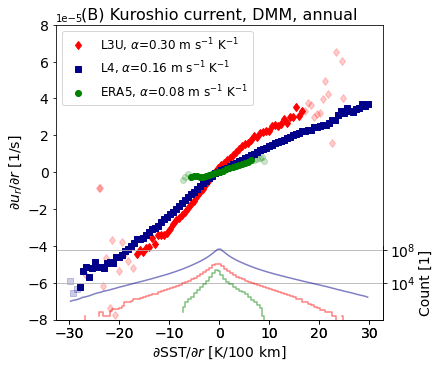

In [83]:
# Figure with smoothed fields only, for the GRL paper.
##### MANUSCRIPT FIGURE #####

fig = plt.figure(figsize=(6., 5.), constrained_layout=True)

threshold_number = 100

ax1 = fig.add_subplot(111)

# Plot the histograms in an inset axis.
axins = ax1.inset_axes([0, 0, 1, 0.25], sharex=ax1)
axins.plot(distribution_control_L4_psi2*factor_a,number_of_points_L4_psi2,color='darkblue',alpha=.5)
axins.step(distribution_control_L3U_psi2*factor_a,number_of_points_L3U_psi2,color='red',alpha=.5)
axins.step(distribution_control_era5_monthly*factor_a,number_of_points_era5_monthly,color='green',alpha=.5)
axins.set_yscale('log')
axins.yaxis.tick_right()
axins.set_ylabel('Count [1]',fontsize=14)
axins.yaxis.set_label_position('right')
axins.tick_params(axis='both', labelsize=14)
axins.spines.top.set_visible(False)
axins.patch.set_alpha(0)
axins.grid(axis='y')
axins.set_yticks([1e4,1e8])

ax1.plot(distribution_control_L4_psi2*factor_a,distribution_L4_psi2*factor_b,'s',color='darkblue',alpha=.2)
ax1.plot(distribution_control_L3U_psi2*factor_a,distribution_L3U_psi2*factor_b,'d',color='red',alpha=.2)
ax1.plot(distribution_control_era5_monthly*factor_a,distribution_era5_monthly*factor_b,'o',color='green',alpha=.2)

# Compute the nonlinear metrics.
sub_slope_L4_psi2, sub_intercept, mdiff, mdiff_negx, mdiff_posx, x5, x95, r_negx_L4_psi2, r_posx_L4_psi2 = nonlinear_metrics(distribution_control_L4_psi2,distribution_L4_psi2,number_of_points_L4_psi2, threshold_number)
sub_slope_L3U_psi2, sub_intercept, mdiff, mdiff_negx, mdiff_posx, x5, x95, r_negx_L3U_psi2, r_posx_L3U_psi2 = nonlinear_metrics(distribution_control_L3U_psi2,distribution_L3U_psi2,number_of_points_L3U_psi2, threshold_number)
sub_slope_ERA5, sub_intercept, mdiff, mdiff_negx, mdiff_posx, x5, x95, r_negx_ERA5, r_posx_ERA5 = nonlinear_metrics(distribution_control_era5_monthly,distribution_era5_monthly,number_of_points_era5_monthly, threshold_number)

ax1.plot(distribution_control_L3U_psi2[number_of_points_L3U_psi2>threshold_number]*factor_a,
         distribution_L3U_psi2[number_of_points_L3U_psi2>threshold_number]*factor_b,'d',color='red',label='L3U, $\\alpha$={s:.2f} '.format(s=sub_slope_L3U_psi2) + units_slope)
ax1.plot(distribution_control_L4_psi2[number_of_points_L4_psi2>threshold_number]*factor_a,
         distribution_L4_psi2[number_of_points_L4_psi2>threshold_number]*factor_b,'s',color='darkblue',label='L4, $\\alpha$={s:.2f} '.format(s=sub_slope_L4_psi2) + units_slope)
ax1.plot(distribution_control_era5_monthly[number_of_points_era5_monthly>threshold_number]*factor_a,
         distribution_era5_monthly[number_of_points_era5_monthly>threshold_number]*factor_b,'o',color='green',label='ERA5, $\\alpha$={s:.2f} '.format(s=sub_slope_ERA5) + units_slope)

ax1.set_xlabel(x_string,fontsize=14)
ax1.set_ylabel(y_string,fontsize=14)
ax1.legend(fontsize=12, loc='upper left')
   
ax1.tick_params(axis='both', labelsize=14)
ax1.set_ylim([-8e-5,8e-5])

str_title = '('+letter_deriv+') '+area_name + ', ' + str_mech + ', ' + str_season
ax1.set_title(str_title, fontsize=16)

#ax0 = ax1.twinx()
#ax0.step(distribution_control_L4_psi2*factor_a,number_of_points_L4_psi2,color='darkblue',alpha=.3)
#ax0.step(distribution_control_L3U_psi2*factor_a,number_of_points_L3U_psi2,color='red',alpha=.3)
#ax0.step(distribution_control_era5_monthly*factor_a,number_of_points_era5_monthly,color='green',alpha=.3)
#ax0.set_yscale('log')
#ax0.set_ylabel('Count [1]',fontsize=14)
#ax0.tick_params(axis='both', labelsize=14)

#axins.set_xticklabels([])

figure_name = 'fb_hist_L4_L3U_psi2_' + area_str + '_' + str_mech + '_' + str_season + '.png'
plt.savefig('./figures/'+figure_name,bbox_inches='tight') 

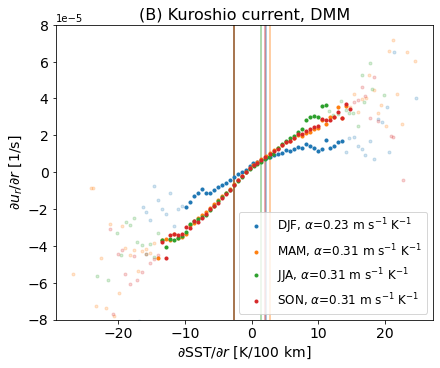

In [84]:
# Figure with smoothed L3U fields only, for the GRL paper. Seasonal variability.
##### MANUSCRIPT FIGURE #####

fig = plt.figure(figsize=(6., 5.), constrained_layout=True)

threshold_number = 100

ax1 = fig.add_subplot(111)

list_str_seasons = ['DJF','MAM','JJA','SON']
ylim_min,ylim_max = -8e-5,8e-5

for jj,season in enumerate(list_str_seasons):
    file2save = 'long_term_distributions_'+area_str+'_'+str_mech+'_'+season+'_sigma'+str(sigma)+'.txt'
    df = pd.read_csv('/media/agostino/twiga-polimi-3/glauco/output_txt/'+file2save)
    #df = pd.read_csv('/media/agostino/sailboat/glauco/output_txt/'+file2save)
    
    distribution_control_L3U_psi2 = df['distribution_control_L3U_psi2']
    distribution_L3U_psi2 = df['distribution_L3U_psi2']
    number_of_points_L3U_psi2 = df['number_of_points_L3U_psi2']

    
    # Select only the points of the binned scatter plot with a high enough number of original points
    sub_slope, sub_intercept, mdiff, mdiff_negx, mdiff_posx, x5, x95, r_negx, r_posx = nonlinear_metrics(distribution_control_L3U_psi2,distribution_L3U_psi2,number_of_points_L3U_psi2, threshold_number)

    ax1.plot(distribution_control_L3U_psi2*factor_a,distribution_L3U_psi2*factor_b,'.',alpha=0.2,color='C'+str(jj))
    ax1.plot(distribution_control_L3U_psi2[number_of_points_L3U_psi2>threshold_number]*factor_a,
             distribution_L3U_psi2[number_of_points_L3U_psi2>threshold_number]*factor_b,'.',label=season + ', $\\alpha$={s:.2f} '.format(s=sub_slope) + units_slope,color='C'+str(jj))

    ax1.vlines(x5*factor_a,ylim_min,ylim_max,'C'+str(jj),alpha=.5)
    ax1.vlines(x95*factor_a,ylim_min,ylim_max,'C'+str(jj),alpha=.5)
    
ax1.set_xlabel(x_string,fontsize=14)
ax1.set_ylabel(y_string,fontsize=14)

if area_str=='eastern_pacific':
    ax1.legend(fontsize=12, loc='upper left')
else:
    ax1.legend(fontsize=12, loc='lower right')

ax1.tick_params(axis='both', labelsize=14)
#ax1.grid()
ax1.set_ylim([ylim_min,ylim_max])

str_title = '('+letter_deriv+') '+area_name + ', ' + str_mech
ax1.set_title(str_title, fontsize=16)

figure_name = 'fb_hist_L3U_psi2_seasonalcycle_' + area_str + '_' + str_mech + '.png'
plt.savefig('./figures/'+figure_name,bbox_inches='tight')

L4_psi0
slope (90% of central points) = 0.12140026635317801
r|x<0 = 1.2638890544717432
r|x>0 = 0.7834908697424368
---------------------------
L4_psi2
slope (90% of central points) = 0.18359169432571962
r|x<0 = 1.3123475994654765
r|x>0 = 0.7351728957396292
---------------------------
L3U_psi0
slope (90% of central points) = 0.04431489340108028
r|x<0 = 1.2819872956581908
r|x>0 = 1.0531736583301814
---------------------------
L3U_psi2
slope (90% of central points) = 0.25888480886138543
r|x<0 = 1.3099627060886812
r|x>0 = 0.7504849485122044
---------------------------


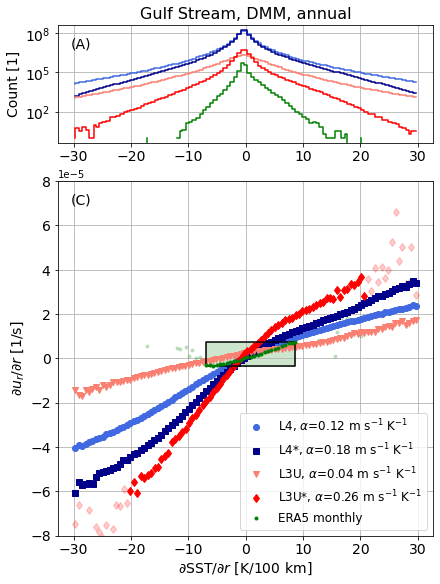

In [14]:
#fig = plt.figure(figsize=(8., 8.), constrained_layout=True)
#spec = fig.add_gridspec(4, 4)
fig = plt.figure(figsize=(6., 8.), constrained_layout=True)
spec = fig.add_gridspec(4, 3)

threshold_number = 100

# Plot the histograms.
ax0 = fig.add_subplot(spec[:1, :3])
ax0.step(distribution_control_L4_psi0*factor_a,number_of_points_L4_psi0,color='royalblue')
ax0.step(distribution_control_L4_psi2*factor_a,number_of_points_L4_psi2,color='darkblue')
ax0.step(distribution_control_L3U_psi0*factor_a,number_of_points_L3U_psi0,color='salmon')
ax0.step(distribution_control_L3U_psi2*factor_a,number_of_points_L3U_psi2,color='red')
ax0.step(distribution_control_era5_monthly*factor_a,number_of_points_era5_monthly,color='green')
ax0.set_yscale('log')
#####ax0.set_xlabel(x_string,fontsize=14)
ax0.set_ylabel('Count [1]',fontsize=14)
ax0.tick_params(axis='both', labelsize=14)
ax0.grid()

# Compute the nonlinear metrics.
sub_slope_L4_psi0, sub_intercept, mdiff, mdiff_negx, mdiff_posx, x5, x95, r_negx_L4_psi0, r_posx_L4_psi0 = nonlinear_metrics(distribution_control_L4_psi0,distribution_L4_psi0,number_of_points_L4_psi0, threshold_number)
print('L4_psi0')
print('slope (90% of central points) = '+ str(sub_slope_L4_psi0))
print('r|x<0 = ' +str(r_negx_L4_psi0))
print('r|x>0 = ' +str(r_posx_L4_psi0))
print('---------------------------')
sub_slope_L4_psi2, sub_intercept, mdiff, mdiff_negx, mdiff_posx, x5, x95, r_negx_L4_psi2, r_posx_L4_psi2 = nonlinear_metrics(distribution_control_L4_psi2,distribution_L4_psi2,number_of_points_L4_psi2, threshold_number)
print('L4_psi2')
print('slope (90% of central points) = '+ str(sub_slope_L4_psi2))
print('r|x<0 = ' +str(r_negx_L4_psi2))
print('r|x>0 = ' +str(r_posx_L4_psi2))
print('---------------------------')
sub_slope_L3U_psi0, sub_intercept, mdiff, mdiff_negx, mdiff_posx, x5, x95, r_negx_L3U_psi0, r_posx_L3U_psi0 = nonlinear_metrics(distribution_control_L3U_psi0,distribution_L3U_psi0,number_of_points_L3U_psi0, threshold_number)
print('L3U_psi0')
print('slope (90% of central points) = '+ str(sub_slope_L3U_psi0))
print('r|x<0 = ' +str(r_negx_L3U_psi0))
print('r|x>0 = ' +str(r_posx_L3U_psi0))
print('---------------------------')
sub_slope_L3U_psi2, sub_intercept, mdiff, mdiff_negx, mdiff_posx, x5, x95, r_negx_L3U_psi2, r_posx_L3U_psi2 = nonlinear_metrics(distribution_control_L3U_psi2,distribution_L3U_psi2,number_of_points_L3U_psi2, threshold_number)
print('L3U_psi2')
print('slope (90% of central points) = '+ str(sub_slope_L3U_psi2))
print('r|x<0 = ' +str(r_negx_L3U_psi2))
print('r|x>0 = ' +str(r_posx_L3U_psi2))
print('---------------------------')

ax1 = fig.add_subplot(spec[1:, :3])
ax1.plot(distribution_control_L4_psi0*factor_a,distribution_L4_psi0*factor_b,'o',color='royalblue',alpha=0.2)
ax1.plot(distribution_control_L4_psi2*factor_a,distribution_L4_psi2*factor_b,'s',color='darkblue',alpha=0.2)
ax1.plot(distribution_control_L3U_psi0*factor_a,distribution_L3U_psi0*factor_b,'v',color='salmon',alpha=0.2)
ax1.plot(distribution_control_L3U_psi2*factor_a,distribution_L3U_psi2*factor_b,'d',color='red',alpha=0.2)
ax1.plot(distribution_control_era5_monthly*factor_a,distribution_era5_monthly*factor_b,'.',color='green',alpha=0.2)

ax1.plot(distribution_control_L4_psi0[number_of_points_L4_psi0>threshold_number]*factor_a,
         distribution_L4_psi0[number_of_points_L4_psi0>threshold_number]*factor_b,'o',color='royalblue',label='L4, $\\alpha$={s:.2f} '.format(s=sub_slope_L4_psi0) + units_slope)
ax1.plot(distribution_control_L4_psi2[number_of_points_L4_psi2>threshold_number]*factor_a,
         distribution_L4_psi2[number_of_points_L4_psi2>threshold_number]*factor_b,'s',color='darkblue',label='L4$*$, $\\alpha$={s:.2f} '.format(s=sub_slope_L4_psi2) + units_slope)
ax1.plot(distribution_control_L3U_psi0[number_of_points_L3U_psi0>threshold_number]*factor_a,
         distribution_L3U_psi0[number_of_points_L3U_psi0>threshold_number]*factor_b,'v',color='salmon',label='L3U, $\\alpha$={s:.2f} '.format(s=sub_slope_L3U_psi0) + units_slope)
ax1.plot(distribution_control_L3U_psi2[number_of_points_L3U_psi2>threshold_number]*factor_a,
         distribution_L3U_psi2[number_of_points_L3U_psi2>threshold_number]*factor_b,'d',color='red',label='L3U$*$, $\\alpha$={s:.2f} '.format(s=sub_slope_L3U_psi2) + units_slope)

# Rectangle of the ERA5 data
minx = np.min(distribution_control_era5_monthly[number_of_points_era5_monthly>threshold_number]*factor_a)
maxx = np.max(distribution_control_era5_monthly[number_of_points_era5_monthly>threshold_number]*factor_a)
miny = np.min(distribution_era5_monthly[number_of_points_era5_monthly>threshold_number]*factor_b)
maxy = np.max(distribution_era5_monthly[number_of_points_era5_monthly>threshold_number]*factor_b)

x = [minx,maxx]
y1 = [miny,miny]
y2 = [maxy,maxy]

plt.fill_between(x,y1,y2,color='green',alpha=0.2)
plt.plot([minx,maxx,maxx,minx,minx],[miny,miny,maxy,maxy,miny],'-k')

ax1.plot(distribution_control_era5_monthly[number_of_points_era5_monthly>threshold_number]*factor_a,
         distribution_era5_monthly[number_of_points_era5_monthly>threshold_number]*factor_b,'.',color='green',label='ERA5 monthly')

ax1.set_xlabel(x_string,fontsize=14)
ax1.set_ylabel(y_string,fontsize=14)
#ax1.legend(['L4, $\\psi=0$ km','L4, $\\psi=10$ km','L3U, $\\psi=0$ km','L3U, $\\psi=10$ km'], fontsize=12,
#           loc='upper left')#loc='lower right')
if area_str=='eastern_pacific':
    ax1.legend(fontsize=12, loc='upper left')
else:
    ax1.legend(fontsize=12, loc='lower right')
    
ax1.tick_params(axis='both', labelsize=14)
ax1.grid()
ax1.set_ylim([-8e-5,8e-5])

# At the moment we still need to compute the histogram of the wind field, which is always the same...
# The only difference is the different subsampling between the L4 and the L3U sets.

str_title = area_name + ', ' + str_mech + ', ' + str_season
ax0.set_title(str_title, fontsize=16)

anchored_text0 = AnchoredText('('+letter_up+')', loc=2, prop=dict(size=14), frameon=False); 
ax0.add_artist(anchored_text0)
anchored_text1 = AnchoredText('('+letter_down+')', loc=2, prop=dict(size=14), frameon=False); 
ax1.add_artist(anchored_text1)
#anchored_text2 = AnchoredText('(c)', loc=2, prop=dict(size=14), frameon=False); 
#ax2.add_artist(anchored_text2)

figure_name = 'fb_distribution_L4_L3U_psi0_psi2_' + area_str + '_' + str_mech + '_' + str_season + '.png'
plt.savefig('./figures/'+figure_name,bbox_inches='tight') 

DJF
slope (90% of central points) = 0.23024562857013986
r|x<0 = 1.1572432730007163
r|x>0 = 0.6763023278827934
---------------------------
MAM
slope (90% of central points) = 0.2686057502898097
r|x<0 = 1.2592857892963953
r|x>0 = 0.7662343316658817
---------------------------
JJA
slope (90% of central points) = 0.2696358118843196
r|x<0 = 1.3549480138427108
r|x>0 = 0.9372054073099855
---------------------------
SON
slope (90% of central points) = 0.25130375788257003
r|x<0 = 1.358498364299335
r|x>0 = 0.7855876267549535
---------------------------


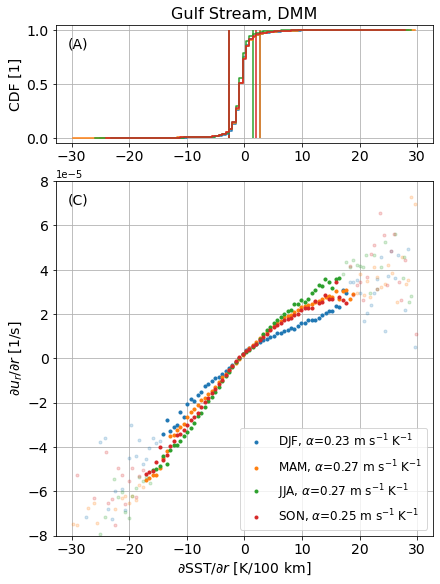

In [15]:
# Here we read the long term distributions and plot the figure with the four seasonal L3U* distributions.

fig = plt.figure(figsize=(6., 8.), constrained_layout=True)
spec = fig.add_gridspec(4, 3)

threshold_number = 100

ax0 = fig.add_subplot(spec[:1, :3])
ax1 = fig.add_subplot(spec[1:, :3])

list_str_seasons = ['DJF','MAM','JJA','SON']

for jj,season in enumerate(list_str_seasons):
    file2save = 'long_term_distributions_'+area_str+'_'+str_mech+'_'+season+'_sigma'+str(sigma)+'.txt'
    df = pd.read_csv('/media/agostino/twiga-polimi-3/glauco/output_txt/'+file2save)
    #df = pd.read_csv('/media/agostino/sailboat/glauco/output_txt/'+file2save)
    
    distribution_control_L3U_psi2 = df['distribution_control_L3U_psi2']
    distribution_L3U_psi2 = df['distribution_L3U_psi2']
    number_of_points_L3U_psi2 = df['number_of_points_L3U_psi2']

    cumulative_points = np.cumsum(number_of_points_L3U_psi2.values)
    
#    ax0.step(distribution_control_L3U_psi2*factor_a,number_of_points_L3U_psi2,color='C'+str(jj))
#    ax0.set_yscale('log')
#    ax0.set_ylabel('Count [1]',fontsize=14)
    ax0.step(distribution_control_L3U_psi2*factor_a,cumulative_points/cumulative_points[-1],color='C'+str(jj))
    ax0.set_ylabel('CDF [1]',fontsize=14)
    ax0.tick_params(axis='both', labelsize=14)
    
    # Select only the points of the binned scatter plot with a high enough number of original points
    #ics = distribution_control_L3U_psi2[number_of_points_L3U_psi2>threshold_number]
    #ipsilon = distribution_L3U_psi2[number_of_points_L3U_psi2>threshold_number]
    #en = number_of_points_L3U_psi2[number_of_points_L3U_psi2>threshold_number]
    sub_slope, sub_intercept, mdiff, mdiff_negx, mdiff_posx, x5, x95, r_negx, r_posx = nonlinear_metrics(distribution_control_L3U_psi2,distribution_L3U_psi2,number_of_points_L3U_psi2, threshold_number)
    print(season)
    print('slope (90% of central points) = '+ str(sub_slope))
    print('r|x<0 = ' +str(r_negx))
    print('r|x>0 = ' +str(r_posx))
    print('---------------------------')

    ax1.plot(distribution_control_L3U_psi2*factor_a,distribution_L3U_psi2*factor_b,'.',alpha=0.2,color='C'+str(jj))
    ax1.plot(distribution_control_L3U_psi2[number_of_points_L3U_psi2>threshold_number]*factor_a,
             distribution_L3U_psi2[number_of_points_L3U_psi2>threshold_number]*factor_b,'.',label=season + ', $\\alpha$={s:.2f} '.format(s=sub_slope) + units_slope,color='C'+str(jj))

    
    ax0.vlines(x5*factor_a,0,1,'C'+str(jj))
    ax0.vlines(x95*factor_a,0,1,'C'+str(jj))
    
ax1.set_xlabel(x_string,fontsize=14)
ax1.set_ylabel(y_string,fontsize=14)
#ax1.legend(['L4, $\\psi=0$ km','L4, $\\psi=10$ km','L3U, $\\psi=0$ km','L3U, $\\psi=10$ km'], fontsize=12,
#           loc='upper left')#loc='lower right')
if area_str=='eastern_pacific':
    ax1.legend(fontsize=12, loc='upper left')
else:
    ax1.legend(fontsize=12, loc='lower right')

ax0.grid()
ax1.tick_params(axis='both', labelsize=14)
ax1.grid()
ax1.set_ylim([-8e-5,8e-5])

str_title = area_name + ', ' + str_mech
ax0.set_title(str_title, fontsize=16)

anchored_text0 = AnchoredText('('+letter_up+')', loc=2, prop=dict(size=14), frameon=False); 
ax0.add_artist(anchored_text0)
anchored_text1 = AnchoredText('('+letter_down+')', loc=2, prop=dict(size=14), frameon=False); 
ax1.add_artist(anchored_text1)
#anchored_text2 = AnchoredText('(c)', loc=2, prop=dict(size=14), frameon=False); 
#ax2.add_artist(anchored_text2)

figure_name = 'fb_distribution_L3U_psi2_seasonalcycle_' + area_str + '_' + str_mech + '.png'
plt.savefig('./figures/'+figure_name,bbox_inches='tight') 

In [ ]:
# This is to plot the figure adding the lines one by one, as for the LPS22 presentation.

#fig = plt.figure(figsize=(8., 8.), constrained_layout=True)
#spec = fig.add_gridspec(4, 4)
fig = plt.figure(figsize=(6., 8.), constrained_layout=True)
spec = fig.add_gridspec(4, 3)

threshold_number = 100

ax0 = fig.add_subplot(spec[:1, :3])
ax0.step(distribution_control_L3U_psi2*factor_a,number_of_points_L3U_psi2,color='red')
ax0.step(distribution_control_L4_psi2*factor_a,number_of_points_L4_psi2,color='darkblue')
ax0.step(distribution_control_L3U_psi0*factor_a,number_of_points_L3U_psi0,color='salmon')
ax0.step(distribution_control_L4_psi0*factor_a,number_of_points_L4_psi0,color='royalblue')
ax0.step(distribution_control_era5_monthly*factor_a,number_of_points_era5_monthly,color='green')
ax0.set_yscale('log')
#ax0.set_xlabel(x_string,fontsize=14)
ax0.set_ylabel('Count [1]',fontsize=14)
ax0.tick_params(axis='both', labelsize=14)
ax0.grid()
ax0.set_ylim([1e-1,1e10])
ax0.set_xlim([-32,32])

ax1 = fig.add_subplot(spec[1:, :3])
ax1.plot(distribution_control_L3U_psi2*factor_a,distribution_L3U_psi2*factor_b,'d',color='red',alpha=0.2)
ax1.plot(distribution_control_L4_psi2*factor_a,distribution_L4_psi2*factor_b,'s',color='darkblue',alpha=0.2)
ax1.plot(distribution_control_L3U_psi0*factor_a,distribution_L3U_psi0*factor_b,'v',color='salmon',alpha=0.2)
ax1.plot(distribution_control_L4_psi0*factor_a,distribution_L4_psi0*factor_b,'o',color='royalblue',alpha=0.2)
ax1.plot(distribution_control_era5_monthly*factor_a,distribution_era5_monthly*factor_b,'.',color='green',alpha=0.2)

ax1.plot(distribution_control_L3U_psi2[number_of_points_L3U_psi2>threshold_number]*factor_a,
         distribution_L3U_psi2[number_of_points_L3U_psi2>threshold_number]*factor_b,'d',color='red',label='L3U$*$, $\\psi=10$ km')
ax1.plot(distribution_control_L4_psi2[number_of_points_L4_psi2>threshold_number]*factor_a,
         distribution_L4_psi2[number_of_points_L4_psi2>threshold_number]*factor_b,'s',color='darkblue',label='L4$*$, $\\psi=10$ km')
ax1.plot(distribution_control_L3U_psi0[number_of_points_L3U_psi0>threshold_number]*factor_a,
         distribution_L3U_psi0[number_of_points_L3U_psi0>threshold_number]*factor_b,'v',color='salmon',label='L3U, $\\psi=0$ km')
ax1.plot(distribution_control_L4_psi0[number_of_points_L4_psi0>threshold_number]*factor_a,
         distribution_L4_psi0[number_of_points_L4_psi0>threshold_number]*factor_b,'o',color='royalblue',label='L4, $\\psi=0$ km')

# Rectangle of the ERA5 data
minx = np.min(distribution_control_era5_monthly[number_of_points_era5_monthly>threshold_number]*factor_a)
maxx = np.max(distribution_control_era5_monthly[number_of_points_era5_monthly>threshold_number]*factor_a)
miny = np.min(distribution_era5_monthly[number_of_points_era5_monthly>threshold_number]*factor_b)
maxy = np.max(distribution_era5_monthly[number_of_points_era5_monthly>threshold_number]*factor_b)

x = [minx,maxx]
y1 = [miny,miny]
y2 = [maxy,maxy]

plt.fill_between(x,y1,y2,color='green',alpha=0.2)
plt.plot([minx,maxx,maxx,minx,minx],[miny,miny,maxy,maxy,miny],'-k')

ax1.plot(distribution_control_era5_monthly[number_of_points_era5_monthly>threshold_number]*factor_a,
         distribution_era5_monthly[number_of_points_era5_monthly>threshold_number]*factor_b,'.',color='green',label='ERA5 monthly')

ax1.set_xlabel(x_string,fontsize=14)
ax1.set_ylabel(y_string,fontsize=14)
#ax1.legend(['L4, $\\psi=0$ km','L4, $\\psi=10$ km','L3U, $\\psi=0$ km','L3U, $\\psi=10$ km'], fontsize=12,
#           loc='upper left')#loc='lower right')
if area_str=='eastern_pacific':
    ax1.legend(fontsize=14, loc='upper left')
else:
    ax1.legend(fontsize=14, loc='lower right')
    
ax1.tick_params(axis='both', labelsize=14)
ax1.grid()
ax1.set_ylim([-8e-5,8e-5])
ax1.set_xlim([-32,32])

# At the moment we still need to compute the histogram of the wind field, which is always the same...
# The only difference is the different subsampling between the L4 and the L3U sets.

str_title = area_name + ', ' + str_mech + ', ' + str_season
ax0.set_title(str_title, fontsize=16)

anchored_text0 = AnchoredText('(a)', loc=2, prop=dict(size=14), frameon=False); 
ax0.add_artist(anchored_text0)
anchored_text1 = AnchoredText('(b)', loc=2, prop=dict(size=14), frameon=False); 
ax1.add_artist(anchored_text1)
#anchored_text2 = AnchoredText('(c)', loc=2, prop=dict(size=14), frameon=False); 
#ax2.add_artist(anchored_text2)

figure_name = 'fb_distribution_L4_L3U_psi0_psi2_' + area_str + '_' + str_mech + '_' + str_season + '_XXX.png'
plt.savefig('./figures/'+figure_name,bbox_inches='tight') 

In [16]:
# Figure for Harmony: show the L3U* and ERA5 data only.
# We also want to compute the daily ERA5 statistics, using data between 2007 and 2010, included.

list_str_start = ['2007-12-01','2008-12-01','2009-12-01']
list_str_end = ['2008-11-30','2009-11-30','2010-11-30']

# Initialize the variables to compute the (fixed) binned distributions with nbins.
if str_mech=='DMM':
    max_control=3; units=1e-4; nbins=100;        

bw=2*max_control/nbins; # Bin width.
    
print('##### ERA5 daily #####')
psi = 0
distribution_control_era5_daily,distribution_era5_daily,number_of_points_era5_daily=fixed_bin_distribution_multiple_files(str_a,str_b,max_control,units,nbins,list_str_start,list_str_end,'ERA5daily',psi)

##### ERA5 daily #####
2007-12-01
2008-12-01
2009-12-01


<ipython-input-14-c247db995ada>:49: RuntimeWarning: invalid value encountered in true_divide
  distribution = distribution_fb/number_of_points_fb
<ipython-input-14-c247db995ada>:50: RuntimeWarning: invalid value encountered in true_divide
  distribution_control = distribution_control_fb*units/number_of_points_fb


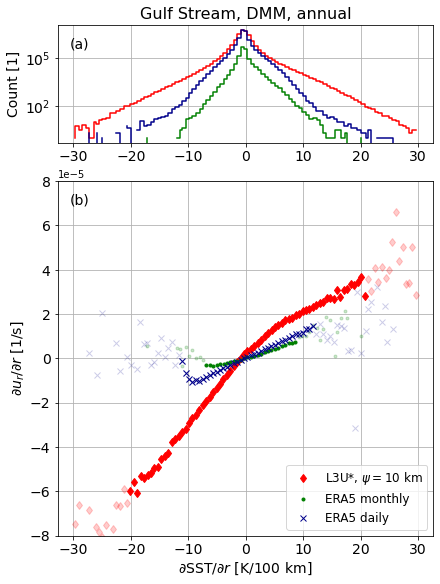

In [18]:
# Factors to change the units in the figures.
factor_a = 1
factor_b = 1

if str_a=='gamma':
    x_string = 'u.grad(SST) [K/s]'; vmin_a=-2.2e-4; vmax_a=2.2e-4
elif str_a=='dsst_dr':
    x_string = '$\partial$SST/$\partial r$ [K/100 km]'; vmin_a=-2.2e-5; vmax_a=2.2e-5; factor_a = 1e5;
elif str_a=='lapl_sst':
    x_string = 'lapl SST [K/m^2]'; vmin_a=-1e-9; vmax_a=1e-9
elif str_a=='d2sst_ds2':
    x_string = 'd2SST/ds2 [K/m^2]'; vmin_a=-1e-9; vmax_a=1e-9

if str_b=='wind_div':
    y_string = 'Wind divergence [1/s]'; vmin_b=-2.2e-4; vmax_b=2.2e-4
elif str_b=='dr_dot_prime_dr':
    y_string = '$\partial u_r/\partial r$ [1/s]'; vmin_b=-2.2e-4; vmax_b=2.2e-4
elif str_b=='ds_dot_prime_ds':
    y_string = 'ds dot prime/ds [1/s]'; vmin_b=-2.2e-4; vmax_b=2.2e-4
    
    
fig = plt.figure(figsize=(6., 8.), constrained_layout=True)
spec = fig.add_gridspec(4, 3)

threshold_number = 100

ax0 = fig.add_subplot(spec[:1, :3])

ax0.step(distribution_control_L3U_psi2*factor_a,number_of_points_L3U_psi2,color='red')
ax0.step(distribution_control_era5_daily*factor_a,number_of_points_era5_daily,color='darkblue')
ax0.step(distribution_control_era5_monthly*factor_a,number_of_points_era5_monthly,color='green')
ax0.set_yscale('log')
#ax0.set_xlabel(x_string,fontsize=14)
ax0.set_ylabel('Count [1]',fontsize=14)
ax0.tick_params(axis='both', labelsize=14)
ax0.grid()

ax1 = fig.add_subplot(spec[1:, :3])
ax1.plot(distribution_control_L3U_psi2*factor_a,distribution_L3U_psi2*factor_b,'d',color='red',alpha=0.2)
ax1.plot(distribution_control_era5_daily*factor_a,distribution_era5_daily*factor_b,'x',color='darkblue',alpha=0.2)
ax1.plot(distribution_control_era5_monthly*factor_a,distribution_era5_monthly*factor_b,'.',color='green',alpha=0.2)

ax1.plot(distribution_control_L3U_psi2[number_of_points_L3U_psi2>threshold_number]*factor_a,
         distribution_L3U_psi2[number_of_points_L3U_psi2>threshold_number]*factor_b,'d',color='red',label='L3U$*$, $\\psi=10$ km')

# Rectangle of the ERA5 data
minx = np.min(distribution_control_era5_monthly[number_of_points_era5_monthly>threshold_number]*factor_a)
maxx = np.max(distribution_control_era5_monthly[number_of_points_era5_monthly>threshold_number]*factor_a)
miny = np.min(distribution_era5_monthly[number_of_points_era5_monthly>threshold_number]*factor_b)
maxy = np.max(distribution_era5_monthly[number_of_points_era5_monthly>threshold_number]*factor_b)

x = [minx,maxx]
y1 = [miny,miny]
y2 = [maxy,maxy]

#plt.fill_between(x,y1,y2,color='green',alpha=0.2)
#plt.plot([minx,maxx,maxx,minx,minx],[miny,miny,maxy,maxy,miny],'-k')

ax1.plot(distribution_control_era5_monthly[number_of_points_era5_monthly>threshold_number]*factor_a,
         distribution_era5_monthly[number_of_points_era5_monthly>threshold_number]*factor_b,'.',color='green',label='ERA5 monthly')
ax1.plot(distribution_control_era5_daily[number_of_points_era5_daily>threshold_number]*factor_a,
         distribution_era5_daily[number_of_points_era5_daily>threshold_number]*factor_b,'x',color='darkblue',label='ERA5 daily')

ax1.set_xlabel(x_string,fontsize=14)
ax1.set_ylabel(y_string,fontsize=14)
#ax1.legend(['L4, $\\psi=0$ km','L4, $\\psi=10$ km','L3U, $\\psi=0$ km','L3U, $\\psi=10$ km'], fontsize=12,
#           loc='upper left')#loc='lower right')
if area_str=='eastern_pacific':
    ax1.legend(fontsize=12, loc='upper left')
else:
    ax1.legend(fontsize=12, loc='lower right')
    
ax1.tick_params(axis='both', labelsize=14)
ax1.grid()
ax1.set_ylim([-8e-5,8e-5])

# At the moment we still need to compute the histogram of the wind field, which is always the same...
# The only difference is the different subsampling between the L4 and the L3U sets.

str_title = area_name + ', ' + str_mech + ', ' + str_season
ax0.set_title(str_title, fontsize=16)

anchored_text0 = AnchoredText('(a)', loc=2, prop=dict(size=14), frameon=False); 
ax0.add_artist(anchored_text0)
anchored_text1 = AnchoredText('(b)', loc=2, prop=dict(size=14), frameon=False); 
ax1.add_artist(anchored_text1)
#anchored_text2 = AnchoredText('(c)', loc=2, prop=dict(size=14), frameon=False); 
#ax2.add_artist(anchored_text2)

figure_name = 'harmony_distribution_L3U_psi2_ERA5_monthly_daily_' + area_str + '_' + str_mech + '_' + str_season + '.png'
plt.savefig('./figures/'+figure_name,bbox_inches='tight') 

10

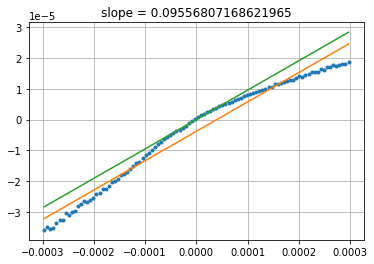

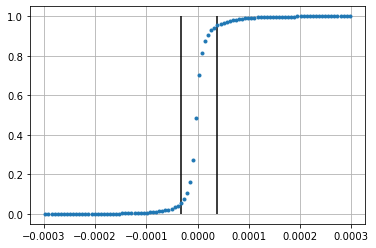

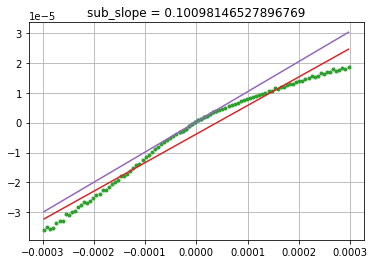

-4.07466427704087e-06
-4.7817310862620845e-06
-3.367597467819656e-06


In [54]:
# Compute the slope of the linear regression. We do not multiply the variables by the factor_a and factor_b, to
# keep using the SI units.

from scipy import stats

x = np.array(distribution_control_L4_psi0)
y = np.array(distribution_L4_psi0)
z = number_of_points_L4_psi0
dx = x[2]-x[1]

# Perform the linear regression.
lsq_res = stats.w(x, y)
slope = lsq_res[0]
intercept = lsq_res[1]
y_fit = slope*x+intercept

plt.plot(x,y,'.')
plt.plot(x,y_fit)
plt.plot(x,y_fit-intercept)
plt.grid()
plt.title('slope = ' + str(slope))
plt.show()

ntot = np.sum(z)
cdf = np.cumsum(z)/ntot
i5 = np.argmin(np.abs(cdf-0.05))
i95 = np.argmin(np.abs(cdf-0.95))
x5 = x[i5]
x95 = x[i95]

ntot = np.sum(z)
plt.plot(x,np.cumsum(z)/ntot,'.')
plt.vlines(x5,0,1,'k')
plt.vlines(x95,0,1,'k')
plt.grid()
plt.show()

sub_x = x[(x>=x5)&(x<=x95)]
sub_y = y[(x>=x5)&(x<=x95)]

sub_lsq_res = stats.linregress(sub_x, sub_y)
sub_slope = sub_lsq_res[0]
sub_intercept = sub_lsq_res[1]
sub_y_fit = sub_slope*sub_x+sub_intercept
plt.plot(sub_x,sub_y,'.')
plt.plot(sub_x,sub_y_fit)

sub_y_fit = sub_slope*x+sub_intercept
plt.plot(x,y,'.')
plt.plot(x,y_fit)
plt.plot(x,sub_y_fit)
plt.grid()
plt.title('sub_slope = ' + str(sub_slope))
plt.show()

error = np.mean(y-sub_y_fit)
error_posx = np.mean(y[x>0]-sub_y_fit[x>0])
error_negx = np.mean(y[x<0]-sub_y_fit[x<0])
print(error)
print(error_posx)
print(error_negx)

In [58]:
def derivative(x,y):
    #from scipy.interpolate import griddata, interp1d

    dx = np.nanmean(np.diff(x))
    y_prime = np.diff(y)/dx
    x_prime = x[:-1]+dx*0.5
    #f_prime = interp1d(x_prime,y_prime,kind='linear',fill_value='extrapolate')
    #return f_prime(x)
    print('dx = '+str(dx))
    print('number of nans '+ str(np.sum(np.isnan(y_prime))))
    
    f_prime = np.interp(x,x_prime,y_prime)
    return f_prime

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def curvature(x,y):
    """
    Compute the signed curvature of a line defined as y=f(x):
        k = f''/(1+f'^2)^(3/2)
    where the prime (') denotes a derivative.
    """
    
    y_p = derivative(x,y)
    y_s = derivative(x,y_p)
    
    return y_s/(1+y_p**2)**(3/2)


No handles with labels found to put in legend.


dx = 0.5997229850540278
number of nans 0
dx = 0.5997229850540278
number of nans 0
dx = 0.5996591665048533
number of nans 0
dx = 0.5996591665048533
number of nans 0
dx = 0.5997462788745548
number of nans 0
dx = 0.5997462788745548
number of nans 0
dx = 0.5993756092295095
number of nans 10
dx = 0.5993756092295095
number of nans 13


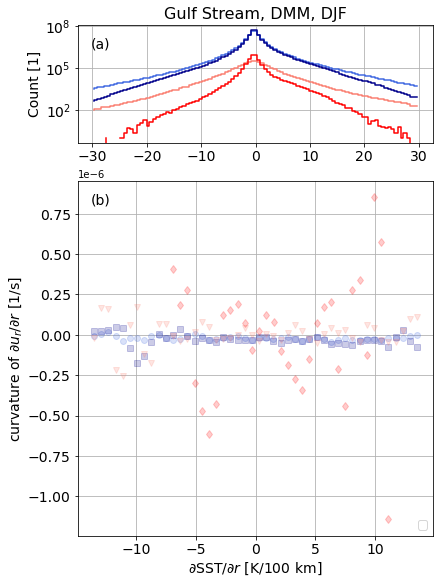

In [69]:
# Compute the curvature of the binned distributions.
fig = plt.figure(figsize=(6., 8.), constrained_layout=True)
spec = fig.add_gridspec(4, 3)

threshold_number = 100
window_av = 55 # To smooth the initial fb distributions.

ax0 = fig.add_subplot(spec[:1, :3])
ax0.step(distribution_control_L4_psi0*factor_a,number_of_points_L4_psi0,color='royalblue')
ax0.step(distribution_control_L4_psi2*factor_a,number_of_points_L4_psi2,color='darkblue')
ax0.step(distribution_control_L3U_psi0*factor_a,number_of_points_L3U_psi0,color='salmon')
ax0.step(distribution_control_L3U_psi2*factor_a,number_of_points_L3U_psi2,color='red')
#ax0.step(distribution_control_era5_monthly*factor_a,number_of_points_era5_monthly,color='green')
ax0.set_yscale('log')
#ax0.set_xlabel(x_string,fontsize=14)
ax0.set_ylabel('Count [1]',fontsize=14)
ax0.tick_params(axis='both', labelsize=14)
ax0.grid()

# Smooth the distributions, otherwise the derivatives are very noisy. A moving average with window_av points is used.

sm_distribution_control_L4_psi0 = moving_average(distribution_control_L4_psi0,window_av)
sm_distribution_L4_psi0 = moving_average(distribution_L4_psi0,window_av)
sm_distribution_control_L4_psi2 = moving_average(distribution_control_L4_psi2,window_av)
sm_distribution_L4_psi2 = moving_average(distribution_L4_psi2,window_av)
sm_distribution_control_L3U_psi0 = moving_average(distribution_control_L3U_psi0,window_av)
sm_distribution_L3U_psi0 = moving_average(distribution_L3U_psi0,window_av)
sm_distribution_control_L3U_psi2 = moving_average(distribution_control_L3U_psi2,window_av)
sm_distribution_L3U_psi2 = moving_average(distribution_L3U_psi2,window_av)


k_L4_psi0 = curvature(sm_distribution_control_L4_psi0*factor_a,sm_distribution_L4_psi0*factor_b)
k_L4_psi2 = curvature(sm_distribution_control_L4_psi2*factor_a,sm_distribution_L4_psi2*factor_b)
k_L3U_psi0 = curvature(sm_distribution_control_L3U_psi0*factor_a,sm_distribution_L3U_psi0*factor_b)
k_L3U_psi2 = curvature(sm_distribution_control_L3U_psi2*factor_a,sm_distribution_L3U_psi2*factor_b)

ax1 = fig.add_subplot(spec[1:, :3])
ax1.plot(sm_distribution_control_L4_psi0*factor_a,k_L4_psi0,'o',color='royalblue',alpha=0.2)
ax1.plot(sm_distribution_control_L4_psi2*factor_a,k_L4_psi2,'s',color='darkblue',alpha=0.2)
ax1.plot(sm_distribution_control_L3U_psi0*factor_a,k_L3U_psi0,'v',color='salmon',alpha=0.2)
ax1.plot(sm_distribution_control_L3U_psi2*factor_a,k_L3U_psi2,'d',color='red',alpha=0.2)
#ax1.plot(sm_distribution_control_L4_psi0*factor_a,sm_distribution_L4_psi0*factor_b,'o',color='royalblue',alpha=0.2)
#ax1.plot(sm_distribution_control_L4_psi2*factor_a,sm_distribution_L4_psi2*factor_b,'s',color='darkblue',alpha=0.2)
#ax1.plot(sm_distribution_control_L3U_psi0*factor_a,sm_distribution_L3U_psi0*factor_b,'v',color='salmon',alpha=0.2)
#ax1.plot(sm_distribution_control_L3U_psi2*factor_a,sm_distribution_L3U_psi2*factor_b,'d',color='red',alpha=0.2)


#ax1.plot(distribution_control_L4_psi0[number_of_points_L4_psi0>threshold_number]*factor_a,
#         k_L4_psi0[number_of_points_L4_psi0>threshold_number],'o',color='royalblue',label='L4, $\\psi=0$ km')
#ax1.plot(distribution_control_L4_psi2[number_of_points_L4_psi2>threshold_number]*factor_a,
#         k_L4_psi2[number_of_points_L4_psi2>threshold_number],'s',color='darkblue',label='L4, $\\psi=10$ km')
#ax1.plot(distribution_control_L3U_psi0[number_of_points_L3U_psi0>threshold_number]*factor_a,
#         k_L3U_psi0[number_of_points_L3U_psi0>threshold_number],'v',color='salmon',label='L3U, $\\psi=0$ km')
#ax1.plot(distribution_control_L3U_psi2[number_of_points_L3U_psi2>threshold_number]*factor_a,
#         k_L3U_psi2[number_of_points_L3U_psi2>threshold_number],'d',color='red',label='L3U, $\\psi=10$ km')

ax1.set_xlabel(x_string,fontsize=14)
ax1.set_ylabel('curvature of '+y_string,fontsize=14)
#ax1.legend(['L4, $\\psi=0$ km','L4, $\\psi=10$ km','L3U, $\\psi=0$ km','L3U, $\\psi=10$ km'], fontsize=12,
#           loc='upper left')#loc='lower right')
if area_str=='eastern_pacific':
    ax1.legend(fontsize=12, loc='upper left')
else:
    ax1.legend(fontsize=12, loc='lower right')
    
ax1.tick_params(axis='both', labelsize=14)
ax1.grid()
#ax1.set_ylim([-1e-5,1e-5])

# At the moment we still need to compute the histogram of the wind field, which is always the same...
# The only difference is the different subsampling between the L4 and the L3U sets.

str_title = area_name + ', ' + str_mech + ', ' + str_season
ax0.set_title(str_title, fontsize=16)

anchored_text0 = AnchoredText('(a)', loc=2, prop=dict(size=14), frameon=False); 
ax0.add_artist(anchored_text0)
anchored_text1 = AnchoredText('(b)', loc=2, prop=dict(size=14), frameon=False); 
ax1.add_artist(anchored_text1)
#anchored_text2 = AnchoredText('(c)', loc=2, prop=dict(size=14), frameon=False); 
#ax2.add_artist(anchored_text2)

figure_name = 'fb_distribution_curvature_L4_L3U_psi0_psi2_' + area_str + '_' + str_mech + '_' + str_season + '.png'

# Even with a moving average, the signal in point-wise curvature is very noisy.
# One might fit a polynomial (2nd or 3rd order) to the curve and then compute the curvature of the polynomial.

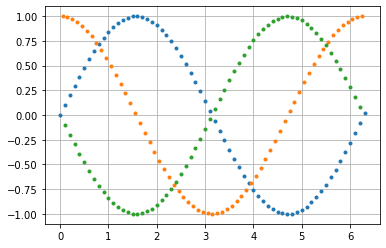

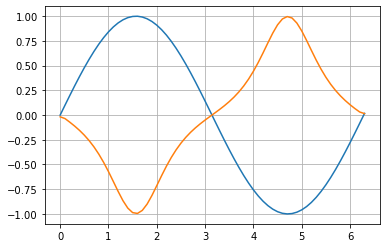

In [43]:
# Test on the curvature.

dx = 0.1
x = np.arange(0,2*np.pi+dx,dx)
y = np.sin(x)

plt.plot(x,y,'.')
plt.grid()

y_prime = np.diff(y)/dx
x_prime = x[:-1]+dx*0.5
plt.plot(x_prime,y_prime,'.')

y_second = np.diff(y_prime)/dx
x_second = x_prime[:-1]+dx*0.5
plt.plot(x_second,y_second,'.')
plt.show()

plt.plot(x,y)

k = curvature(x,y)
plt.plot(x,k)
plt.grid()

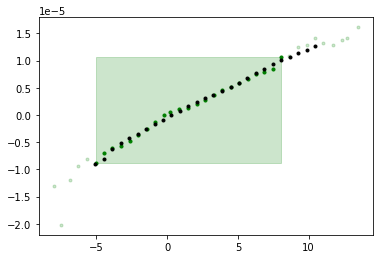

In [60]:
plt.plot(distribution_control_era5_monthly*factor_a,distribution_era5_monthly*factor_b,'.',color='green',alpha=0.2)
plt.plot(distribution_control_era5_monthly[number_of_points_era5_monthly>threshold_number]*factor_a,
         distribution_era5_monthly[number_of_points_era5_monthly>threshold_number]*factor_b,'.',color='green',label='ERA5 monthly')

smooth_x = moving_average(distribution_control_era5_monthly,11)
smooth_distr = moving_average(distribution_era5_monthly,11)
plt.plot(smooth_x*factor_a,smooth_distr*factor_b,'.',color='k')


x = [np.min(distribution_control_era5_monthly[number_of_points_era5_monthly>threshold_number]*factor_a),
     np.max(distribution_control_era5_monthly[number_of_points_era5_monthly>threshold_number]*factor_a)]
y1 = [np.min(distribution_era5_monthly[number_of_points_era5_monthly>threshold_number]*factor_b),
      np.min(distribution_era5_monthly[number_of_points_era5_monthly>threshold_number]*factor_b)]
y2 = [np.max(distribution_era5_monthly[number_of_points_era5_monthly>threshold_number]*factor_b),
      np.max(distribution_era5_monthly[number_of_points_era5_monthly>threshold_number]*factor_b)]

plt.fill_between(x,y1,y2,color='green',alpha=0.2)

In [11]:
# Set the time frame of interest: read a SST file for each day and all the corresponding wind swaths.
# The first and last days ('YYYY-MM-DD') are included in the analysis.
str_start = '2009-12-01'; str_end = '2010-02-28'; str_season='DJF' # winter
#str_start = '2010-03-01'; str_end = '2010-05-31'; str_season='MAM' # spring
str_start = '2010-06-01'; str_end = '2010-08-31'; str_season='JJA' # summer
#str_start = '2010-09-01'; str_end = '2010-11-30'; str_season='SON' # fall
#str_start = '2009-12-01'; str_end = '2010-11-30'; # annual

In [12]:
# Select here the fields to be analysed.
str_a = 'dsst_dr' # Choose between: 'gamma', 'dsst_dr', 'lapl_sst', 'd2sst_ds2'
str_b = 'dr_dot_prime_dr' # Choose between: 'wind_div', 'dr_dot_prime_dr', 'ds_dot_prime_ds'
str_mech = 'DMM' # Choose between: 'DMM', 'PA'

# Select the standard deviation of the Gaussian filter used to determine the background wind field.
sigma = 10 # Take a relatively local sigma, to highlight the small scale features. If we take 5 the correlation
# seems to be less significant: we problably go to too fine scales... Standard value: sigma = 10.

psi = 4

eastern_pacific_allvalues_dr_dot_prime_dr_vs_dsst_dr_from_2010-06-01_to_2010-08-31_sigma10.txt


/home/agostino/glauco/distributions.py:478: RuntimeWarning: divide by zero encountered in double_scalars
  t_value = np.abs(sr_distr)*np.sqrt((df)/(1-sr_distr**2))
/home/agostino/glauco/distributions.py:478: RuntimeWarning: divide by zero encountered in double_scalars
  t_value = np.abs(sr_distr)*np.sqrt((df)/(1-sr_distr**2))


(1.0, 0.0)

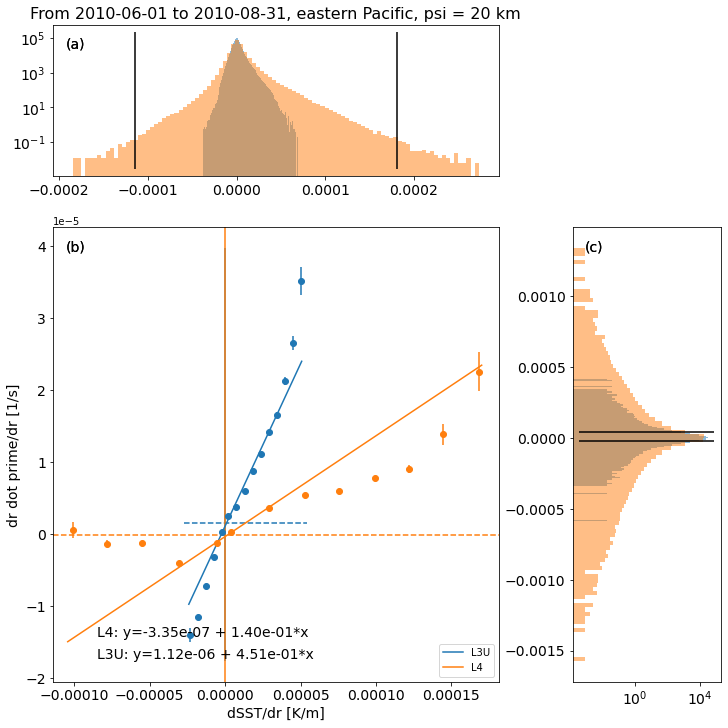

In [13]:
# Plot the distributions of the analyses of the same variable using the L4 and the L3U SST data.
perc_step = 5
if psi==0:
    str_title = 'From ' + str_start + ' to ' + str_end + ', ' +  area_name 
    str_name = 'from_' + str_start + '_to_' + str_end + '_' + area_str + '_sigma' + str(sigma) +'_mask'
else:
    str_title = 'From ' + str_start + ' to ' + str_end + ', ' +  area_name + ', psi = '+str(psi*5)+' km'
    str_name = 'from_' + str_start + '_to_' + str_end + '_' + area_str + '_sigma' + str(sigma) +'_mask_psi'+str(psi)

xlimiti=np.nan; ylimiti=np.nan

if str_a=='gamma':
    x_string = 'u.grad(SST) [K/s]'; vmin_a=-2.2e-4; vmax_a=2.2e-4
elif str_a=='dsst_dr':
    x_string = 'dSST/dr [K/m]'; vmin_a=-2.2e-5; vmax_a=2.2e-5
elif str_a=='lapl_sst':
    x_string = 'lapl SST [K/m^2]'; vmin_a=-1e-9; vmax_a=1e-9
elif str_a=='d2sst_ds2':
    x_string = 'd2SST/ds2 [K/m^2]'; vmin_a=-1e-9; vmax_a=1e-9

if str_b=='wind_div':
    y_string = 'Wind divergence [1/s]'; vmin_b=-2.2e-4; vmax_b=2.2e-4
elif str_b=='dr_dot_prime_dr':
    y_string = 'dr dot prime/dr [1/s]'; vmin_b=-2.2e-4; vmax_b=2.2e-4
elif str_b=='ds_dot_prime_ds':
    y_string = 'ds dot prime/ds [1/s]'; vmin_b=-2.2e-4; vmax_b=2.2e-4


# Read the existing files for the L4 and L3U data.
if psi==0:
    file2read = area_str + '_allvalues_' + str_b + '_vs_' + str_a + '_from_' + str_start + '_to_' + str_end + '_sigma' + str(sigma) + '_L3Usst.txt'
    file2readU = area_str + '_allvalues_' + str_b + '_vs_' + str_a + '_from_' + str_start + '_to_' + str_end + '_sigma' + str(sigma) + '_L3Usst_psi2.txt'
else:
    file2read = area_str + '_allvalues_' + str_b + '_vs_' + str_a + '_from_' + str_start + '_to_' + str_end + '_sigma' + str(sigma) + '_L3Usst_psi' + str(psi) + '.txt'
    file2readU = file2read

df = pd.read_csv('./output_txt/'+file2read)
aL3U = df['control']
bL3U = df['response']
dfU = pd.read_csv('./output_txt/'+file2readU)
UL3U = dfU['background_ws']

file2read = area_str + '_allvalues_' + str_b + '_vs_' + str_a + '_from_' + str_start + '_to_' + str_end + '_sigma' + str(sigma) + '.txt'
print(file2read)
df = pd.read_csv('./output_txt/'+file2read)
aL4 = df['control']
bL4 = df['response']
UL4 = df['background_ws']

str_legend = ['L3U','L4']
dstr.mixed_distribution_with_hist_two_samples(aL3U,bL3U,aL4,bL4,str_a,str_b,str_legend,xlimiti,ylimiti,x_string,
                                              y_string,perc_step,title=str_title,str_name=str_name)

/home/agostino/glauco/distributions.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  t_value = np.abs(sr_distr)*np.sqrt((df)/(1-sr_distr**2))
/home/agostino/glauco/distributions.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  t_value = np.abs(sr_distr)*np.sqrt((df)/(1-sr_distr**2))
/home/agostino/glauco/distributions.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  t_value = np.abs(sr_distr)*np.sqrt((df)/(1-sr_distr**2))
/home/agostino/glauco/distributions.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  t_value = np.abs(sr_distr)*np.sqrt((df)/(1-sr_distr**2))
/home/agostino/glauco/distributions.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  t_value = np.abs(sr_distr)*np.sqrt((df)/(1-sr_distr**2))


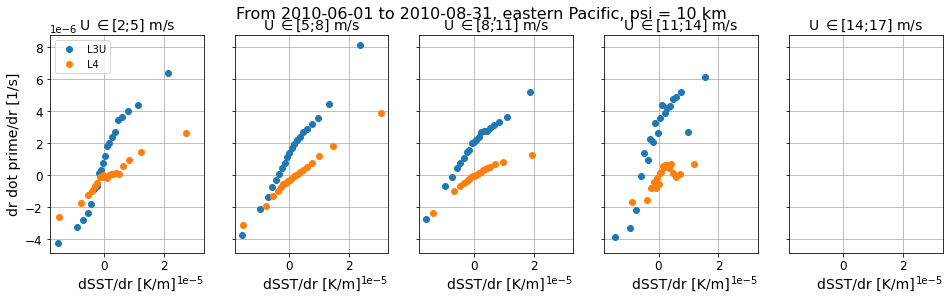

In [18]:
# Plot the comparison for different ranges of background wind speed.

max_ws = 16
confidence_level=0.01

ustep = 3 # ustep = 2.5
U_set = np.arange(2,max_ws,ustep)

fig, ax = plt.subplots(1,len(U_set),figsize=(16, 4), sharex=True, sharey=True)
for ii in range(len(U_set)):
    uu = U_set[ii]
    ax[ii].set_title('U $\\in$['+str(uu)+';'+str(uu+ustep)+'] m/s', fontsize=14)
    
    idu_L3U = [(UL3U>uu)&(UL3U<uu+ustep)] # Logical mask to select the other fields.
    idu_L3U = np.squeeze(idu_L3U)
    au_L3U = aL3U[idu_L3U]
    bu_L3U = bL3U[idu_L3U]
    idu_L4 = [(UL4>uu)&(UL4<uu+ustep)] # Logical mask to select the other fields.
    idu_L4 = np.squeeze(idu_L4)
    au_L4 = aL4[idu_L4]
    bu_L4 = bL4[idu_L4]

    if au_L3U.size>0:
        slope,intercept,sr_distr,p_value_L3U,distr_control_L3U,distr_L3U=dstr.metrics_percentile_distribution(au_L3U,bu_L3U,perc_step=5)
        slope,intercept,sr_distr,p_value_L4,distr_control_L4,distr_L4=dstr.metrics_percentile_distribution(au_L4,bu_L4,perc_step=5)

        if p_value_L3U<confidence_level:
            ax[ii].plot(distr_control_L3U,distr_L3U,'o')
        else:
            ax[ii].plot(distr_control_L3U,distr_L3U,'x')
        if p_value_L4<confidence_level:
            ax[ii].plot(distr_control_L4,distr_L4,'o')
        else:
            ax[ii].plot(distr_control_L4,distr_L4,'x')
    
    if ii==0:
        ax[ii].legend(['L3U','L4'])
        ax[ii].set_ylabel(y_string,fontsize=14)
    ax[ii].set_xlabel(x_string,fontsize=14)
    ax[ii].grid()
    ax[ii].tick_params(axis='both', labelsize=12)

plt.suptitle(str_title, fontsize=16)

figure_name = 'comparison_perc_distr_L4_L3U_psi'+str(psi)+'_'+area_str+'_'+str_mech+'_'+str_season+'.png'
plt.savefig('./figures/'+figure_name,bbox_inches='tight')

/home/agostino/glauco/distributions.py:478: RuntimeWarning: divide by zero encountered in double_scalars
  t_value = np.abs(sr_distr)*np.sqrt((df)/(1-sr_distr**2))
/home/agostino/glauco/distributions.py:478: RuntimeWarning: divide by zero encountered in double_scalars
  t_value = np.abs(sr_distr)*np.sqrt((df)/(1-sr_distr**2))


(1.0, 0.0)

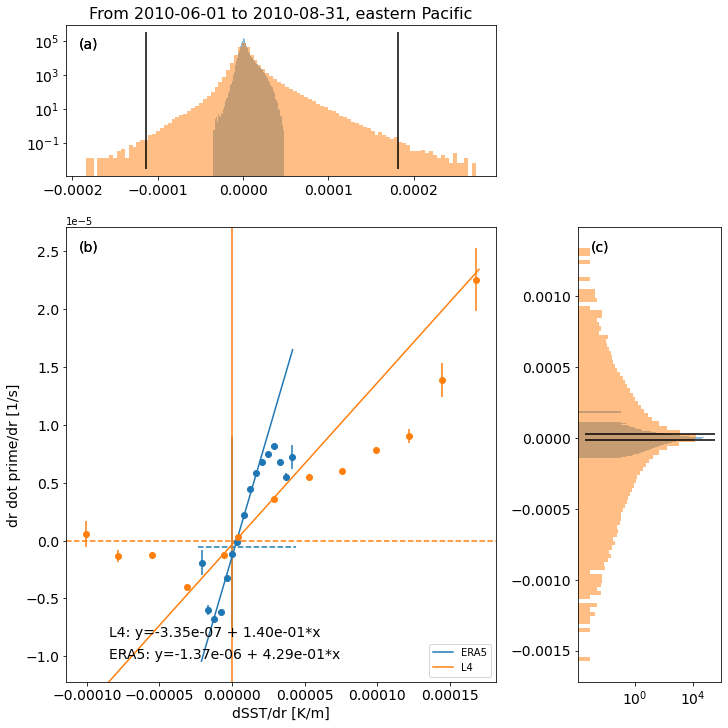

In [13]:
# Here compare ERA5 stats with L4.
# Here nothing depends on psi.

perc_step = 5
str_title = 'From ' + str_start + ' to ' + str_end + ', ' +  area_name 
str_name = 'from_' + str_start + '_to_' + str_end + '_' + area_str + '_sigma' + str(sigma) +'_mask'

xlimiti=np.nan; ylimiti=np.nan

if str_a=='gamma':
    x_string = 'u.grad(SST) [K/s]'; vmin_a=-2.2e-4; vmax_a=2.2e-4
elif str_a=='dsst_dr':
    x_string = 'dSST/dr [K/m]'; vmin_a=-2.2e-5; vmax_a=2.2e-5
elif str_a=='lapl_sst':
    x_string = 'lapl SST [K/m^2]'; vmin_a=-1e-9; vmax_a=1e-9
elif str_a=='d2sst_ds2':
    x_string = 'd2SST/ds2 [K/m^2]'; vmin_a=-1e-9; vmax_a=1e-9

if str_b=='wind_div':
    y_string = 'Wind divergence [1/s]'; vmin_b=-2.2e-4; vmax_b=2.2e-4
elif str_b=='dr_dot_prime_dr':
    y_string = 'dr dot prime/dr [1/s]'; vmin_b=-2.2e-4; vmax_b=2.2e-4
elif str_b=='ds_dot_prime_ds':
    y_string = 'ds dot prime/ds [1/s]'; vmin_b=-2.2e-4; vmax_b=2.2e-4

# Read the existing files for the ERA5 data.

file2read = area_str + '_allvalues_' + str_b + '_vs_' + str_a + '_from_' + str_start + '_to_' + str_end + '_sigma' + str(sigma) + '_era5daily.txt'

df = pd.read_csv('./output_txt/'+file2read)
aE5 = df['control']
bE5 = df['response']
UE5 = df['background_ws']

# Read the existing files for the L4 data.

file2read = area_str + '_allvalues_' + str_b + '_vs_' + str_a + '_from_' + str_start + '_to_' + str_end + '_sigma' + str(sigma) + '.txt'

df = pd.read_csv('./output_txt/'+file2read)
aL4 = df['control']
bL4 = df['response']
UL4 = df['background_ws']

str_legend = ['ERA5','L4']
dstr.mixed_distribution_with_hist_two_samples(aE5,bE5,aL4,bL4,str_a,str_b,str_legend,xlimiti,ylimiti,x_string,
                                              y_string,perc_step,title=str_title,str_name=str_name)

/home/agostino/glauco/distributions.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  t_value = np.abs(sr_distr)*np.sqrt((df)/(1-sr_distr**2))
/home/agostino/glauco/distributions.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  t_value = np.abs(sr_distr)*np.sqrt((df)/(1-sr_distr**2))
/home/agostino/glauco/distributions.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  t_value = np.abs(sr_distr)*np.sqrt((df)/(1-sr_distr**2))
/home/agostino/glauco/distributions.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  t_value = np.abs(sr_distr)*np.sqrt((df)/(1-sr_distr**2))


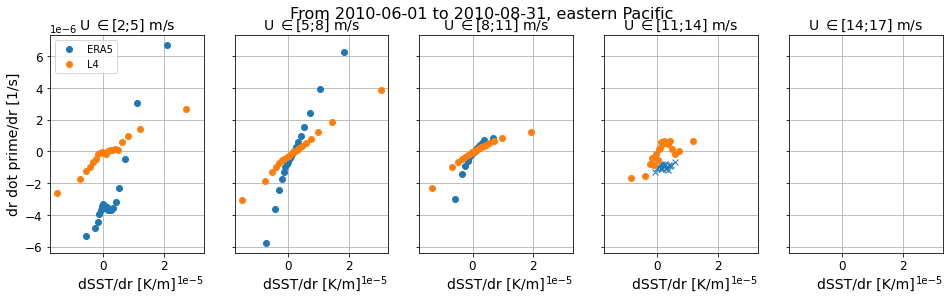

In [14]:
# Plot the comparison for different ranges of background wind speed.

max_ws = 16
confidence_level=0.01

ustep = 3 # ustep = 2.5
U_set = np.arange(2,max_ws,ustep)

fig, ax = plt.subplots(1,len(U_set),figsize=(16, 4), sharex=True, sharey=True)
for ii in range(len(U_set)):
    uu = U_set[ii]
    ax[ii].set_title('U $\\in$['+str(uu)+';'+str(uu+ustep)+'] m/s', fontsize=14)
    
    idu_E5 = [(UE5>uu)&(UE5<uu+ustep)] # Logical mask to select the other fields.
    idu_E5 = np.squeeze(idu_E5)
    au_E5 = aE5[idu_E5]
    bu_E5 = bE5[idu_E5]
    idu_L4 = [(UL4>uu)&(UL4<uu+ustep)] # Logical mask to select the other fields.
    idu_L4 = np.squeeze(idu_L4)
    au_L4 = aL4[idu_L4]
    bu_L4 = bL4[idu_L4]

    if au_E5.size>0:
        slope,intercept,sr_distr,p_value_E5,distr_control_E5,distr_E5=dstr.metrics_percentile_distribution(au_E5,bu_E5,perc_step=5)
        slope,intercept,sr_distr,p_value_L4,distr_control_L4,distr_L4=dstr.metrics_percentile_distribution(au_L4,bu_L4,perc_step=5)

        if p_value_E5<confidence_level:
            ax[ii].plot(distr_control_E5,distr_E5,'o')
        else:
            ax[ii].plot(distr_control_E5,distr_E5,'x')
        if p_value_L4<confidence_level:
            ax[ii].plot(distr_control_L4,distr_L4,'o')
        else:
            ax[ii].plot(distr_control_L4,distr_L4,'x')
    
    if ii==0:
        ax[ii].legend(['ERA5','L4'])
        ax[ii].set_ylabel(y_string,fontsize=14)
    ax[ii].set_xlabel(x_string,fontsize=14)
    ax[ii].grid()
    ax[ii].tick_params(axis='both', labelsize=12)

plt.suptitle(str_title, fontsize=16)

figure_name = 'comparison_perc_distr_L4_ERA5_'+area_str+'_'+str_mech+'_'+str_season+'.png'
plt.savefig('./figures/'+figure_name,bbox_inches='tight')

/home/agostino/glauco/distributions.py:478: RuntimeWarning: divide by zero encountered in double_scalars
  t_value = np.abs(sr_distr)*np.sqrt((df)/(1-sr_distr**2))
/home/agostino/glauco/distributions.py:429: RuntimeWarning: Mean of empty slice
  distribution_fb[qq] = np.nanmean(variable[(control>=lower)&(control<upper)])
/home/agostino/miniconda3/envs/eureca/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/agostino/glauco/distributions.py:431: RuntimeWarning: Mean of empty slice
  distribution_control_fb[qq] = np.nanmean(control[(control>=lower)&(control<upper)])
/home/agostino/glauco/distributions.py:429: RuntimeWarning: Mean of empty slice
  distribution_fb[qq] = np.nanmean(variable[(control>=lower)&(control<upper)])
/home/agostino/miniconda3/envs/eureca/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for

(0.724812030075188, 0.00015011527308872452)

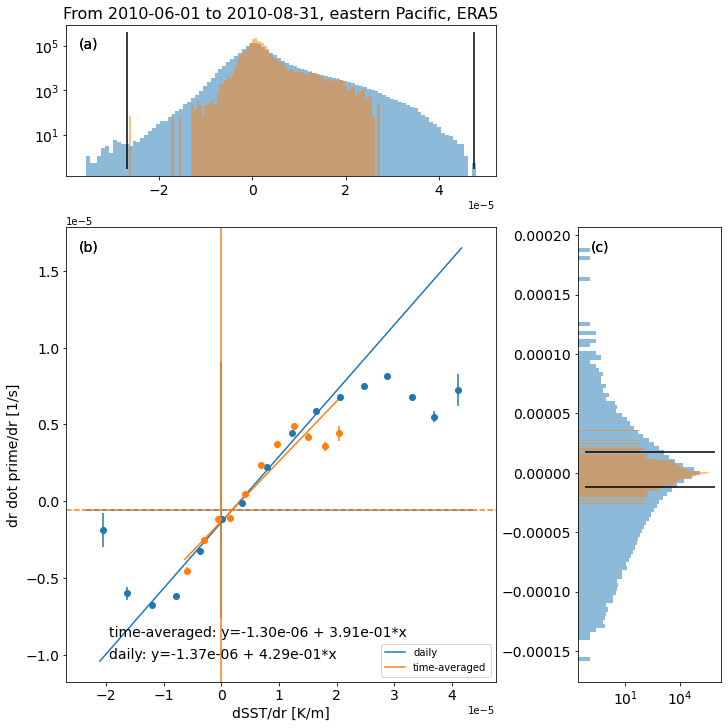

In [15]:
# Here compare ERA5 daily data and the ERA5 time averaged data.
# Here nothing depends on psi.

perc_step = 5
str_title = 'From ' + str_start + ' to ' + str_end + ', ' +  area_name + ', ERA5'
str_name = 'from_' + str_start + '_to_' + str_end + '_' + area_str + '_sigma' + str(sigma) +'_mask'

xlimiti=np.nan; ylimiti=np.nan

if str_a=='gamma':
    x_string = 'u.grad(SST) [K/s]'; vmin_a=-2.2e-4; vmax_a=2.2e-4
elif str_a=='dsst_dr':
    x_string = 'dSST/dr [K/m]'; vmin_a=-2.2e-5; vmax_a=2.2e-5
elif str_a=='lapl_sst':
    x_string = 'lapl SST [K/m^2]'; vmin_a=-1e-9; vmax_a=1e-9
elif str_a=='d2sst_ds2':
    x_string = 'd2SST/ds2 [K/m^2]'; vmin_a=-1e-9; vmax_a=1e-9

if str_b=='wind_div':
    y_string = 'Wind divergence [1/s]'; vmin_b=-2.2e-4; vmax_b=2.2e-4
elif str_b=='dr_dot_prime_dr':
    y_string = 'dr dot prime/dr [1/s]'; vmin_b=-2.2e-4; vmax_b=2.2e-4
elif str_b=='ds_dot_prime_ds':
    y_string = 'ds dot prime/ds [1/s]'; vmin_b=-2.2e-4; vmax_b=2.2e-4

# Read the existing files for the ERA5 daily data.

file2read = area_str + '_allvalues_' + str_b + '_vs_' + str_a + '_from_' + str_start + '_to_' + str_end + '_sigma' + str(sigma) + '_era5daily.txt'

df = pd.read_csv('./output_txt/'+file2read)
aE5 = df['control']
bE5 = df['response']
UE5 = df['background_ws']

# Read the existing files for the time-averaged ERA5 data.

file2read = area_str + '_allvalues_' + str_b + '_vs_' + str_a + '_from_' + str_start + '_to_' + str_end + '_sigma' + str(sigma) + '_era5daily_time_average.txt'

df = pd.read_csv('./output_txt/'+file2read)
aE5_avg = df['control']
bE5_avg = df['response']

str_legend = ['daily','time-averaged']
dstr.mixed_distribution_with_hist_two_samples(aE5,bE5,aE5_avg,bE5_avg,str_a,str_b,str_legend,xlimiti,ylimiti,x_string,
                                              y_string,perc_step,title=str_title,str_name=str_name)